# PLAN

- [x] Acquisition
    - [x] Select what list of repos to scrape.
    - [x] Get requests from the site.
    - [x] Save responses to csv.
- [x] Preparation
    - [x] Prepare the data for analysis.
- [x] Exploration
    - [x] Answer the following prompts:
        - [x] What are the most common words in READMEs?
        - [x] What does the distribution of IDFs look like for the most common words?
        - [x] Does the length of the README vary by language?
        - [x] Do different languages use a different number of unique words?
- [x] Modeling
    - [x] Transform the data for machine learning; use language to predict.
    - [x] Fit several models using different text representations.
    - [x] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [x] README file in the repo.
        - [x] Python scripts if applicable. (We've decided to self-contain in ipynb only.)
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [1]:
import os
import sys

import pandas as pd
import re
import json
import unicodedata
import nltk
import spacy
import random
random.seed(493)

from requests import get
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

# Removed python and javascript as stopwords because these words DO ADD meaning to the text.
# ADDITIONAL_STOPWORDS = ['readme', '\n\n\n', '-PRON-', 'python', 'javascript']
ADDITIONAL_STOPWORDS = ['readme', '\n\n\n', '-PRON-']

# ACQUIRE

In [2]:
# We have decided to search Github for "san antonio data" and scrape the results.
# https://github.com/open-austin

In [3]:
def get_github_repo(url):
    """
    This function takes a url and returns a dictionary that
    contains the content and language of the readme file.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    readme = soup.find('div', id='readme')
    language = soup.find('span', class_='lang')
    
    d = dict()
    if readme is None:
        d['readme'] = 'No readme file.'
    else:
        d['readme'] = readme.text
    if language is None:
        d['language'] = 'No language specified.'
    else:
        d['language'] = language.text
    return d

In [4]:
# # This line to test out the function.
# get_github_repo('https://github.com/open-austin/atx-citysdk-js')

In [5]:
def get_github_links(url):
    """
    This function takes in a url and returns a list of links
    that comes from each individual repo listing page.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.findAll('a', itemprop='name codeRepository', attrs={'href': re.compile("^/")}):
        links.append(link.get('href'))
    return links

In [6]:
# # This line to test out the function.
# get_github_links('https://github.com/open-austin?page=3')

In [7]:
def get_all_github_links(path, num_pages):
    """
    This function takes in a url path and number of pages
    and returns a list of lists of all links.
    """
    all_links = []
    for i in range(num_pages):      # Number of pages plus one
        page = i + 1
        response = get(path + str(page))
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links.append(get_github_links(path + '?page=' + str(page)))
    return all_links

In [8]:
# # This line to test out the function.
# get_all_github_links('https://github.com/open-austin', 3)

In [9]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [10]:
def get_github_readme(url, num_pages, cache=True):
    if cache and os.path.exists('github_readme.json'):
        readme_text = json.load(open('github_readme.json'))
    else:
        data = get_all_github_links(url, num_pages)
        readme_text = []
        for value in traverse(data):
            print('https://github.com'+value)
            readme_text.append(get_github_repo('https://github.com' + value))
        json.dump(readme_text, open('github_readme.json', 'w'))
    return readme_text

In [11]:
# Bringing it all together chaining...
from pprint import pprint
corpus = get_github_readme('https://github.com/texastribune', 8, cache=True)
pprint(corpus)

[{'language': 'Dockerfile',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.md\n'
            '      \n'
            '\n'
            '\n'
            'Base images\n'
            'How to make updates:\n'
            '\n'
            'Create a new branch\n'
            "If you're adding a python dependency:\n"
            '\n'
            'Run make run-base\n'
            "Run poetry add --dev <package> (drop the --dev if it's a "
            'production\n'
            'dependency)\n'
            'For other operations see the\n'
            'poetry docs\n'
            'Maybe edit pyproject.toml by hand if necessary\n'
            'Run poetry lock\n'
            '\n'
            '\n'
            "If it's a node dependency:\n"
            '\n'
            'Run make run-dev\n'
            'Do whatever node/yarn things you people do ;-)\n'
            '\n'
            '\n'
            'Bump the version in VERSION file\n'
            'Bump vers

            'https://github.com/stdbrouw/django-locking\n'
            'https://github.com/runekaagaard/django-locking\n'
            'https://github.com/theatlantic/django-locking\n'
            'https://github.com/ortsed/django-locking\n'
            '\n'
            '\n'},
 {'language': 'No language specified.', 'readme': 'No readme file.'},
 {'language': 'Python',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.md\n'
            '      \n'
            '\n'
            '\n'
            'yourls\n'
            'Simple Docker container for YOURLS.\n'
            'Usage\n'
            'Available on Docker Hub as texastribune/yourls.\n'
            '$ docker run \\\n'
            '    -e YOURLS_DB_USER=root \\\n'
            '    -e YOURLS_DB_PASS=supersecureyo \\\n'
            '    -e YOURLS_DB_NAME=yourls \\\n'
            '    -e YOURLS_DB_HOST=localhost \\\n'
            '    -e YOURLS_DB_PREFIX=yourls_ \\\n'
            '    -e YOURLS

            '├── grunt-build.bat\n'
            '├── grunt-dev.command\n'
            '├── grunt-dev.bat\n'
            '├── package.json\n'
            '├── README.md\n'
            '├── .editorconfig\n'
            '├── .gitignore\n'
            '├── .jshintrc\n'
            '└── .travis.yml\n'
            '\n'
            'Roadmap\n'
            "Projected roadmap for FireShell and it's subsets builds.\n"
            '\n'
            'Integrate Grunt-init to allow for initial project naming (for '
            'dynamic CSS/JS banners)\n'
            'LESS.css variant (less dir inside src), keeping Sass as default '
            'but providing Gruntfile.js setup\n'
            'AngularJS FireShell build with MVC scaffolding\n'
            'Bower as package manager\n'
            'Static HTML Includes FireShell build (emulates server-side '
            'includes)\n'
            'PHP FireShell spawning a localhost with relevant includes\n'
            'Create a Yeoman generator for FireS

            '\t<!-- .slide: data-background="#ff0000" -->\n'
            '\t\tMarkdown content\n'
            '\t</script>\n'
            '</section>\n'
            'Configuration\n'
            'At the end of your page you need to initialize reveal by running '
            'the following code. Note that all config values are optional and '
            'will default as specified below.\n'
            'Reveal.initialize({\n'
            '\n'
            '\t// Display controls in the bottom right corner\n'
            '\tcontrols: true,\n'
            '\n'
            '\t// Display a presentation progress bar\n'
            '\tprogress: true,\n'
            '\n'
            '\t// Display the page number of the current slide\n'
            '\tslideNumber: false,\n'
            '\n'
            '\t// Push each slide change to the browser history\n'
            '\thistory: false,\n'
            '\n'
            '\t// Enable keyboard shortcuts for navigation\n'
            '\tkeyboard: true,

            'app-template, see our development environment blog post.\n'
            "What's in here?\n"
            'The project contains the following folders and important files:\n'
            '\n'
            'confs -- Server configuration files for nginx and uwsgi. Edit the '
            "templates then fab <ENV> servers.render_confs, don't edit "
            'anything in confs/rendered directly.\n'
            'data -- Data files, such as those used to generate HTML.\n'
            'fabfile -- Fabric commands for automating setup, deployment, data '
            'processing, etc.\n'
            'etc -- Miscellaneous scripts and metadata for project '
            'bootstrapping.\n'
            'jst -- Javascript (Underscore.js) templates.\n'
            'less -- LESS files, will be compiled to CSS and concatenated for '
            'deployment.\n'
            'templates -- HTML (Jinja2) templates, to be compiled locally.\n'
            'tests -- Python unit tests.\n'
            '

            'deleted duplicate icons (twitter and twitter-bird)\n'
            '\n'
            '\n'
            'Version 0.5:\n'
            '\n'
            'added tt logo bug\n'
            '\n'
            '\n'
            'Version 0.4:\n'
            '\n'
            'added flexslider nav\n'
            '\n'
            '\n'
            'Version 0.3:\n'
            '\n'
            'add share-alt\n'
            'font-awesome-ize the icons\n'
            '\n'
            '\n'
            'Version 0.2:\n'
            '\n'
            'added a copy of Best and Worst game (game uses another font '
            'icon)\n'
            'added some other icons that we currently use on the site\n'
            '\n'
            '\n'
            'Version 0.1: Festival\n'
            '\n'
            '\n'
            '\n'},
 {'language': 'Python',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.rst\n'
            '      \n'
            '\n'
       

            "SENTRY_REMOTE_URL = ['http://server1/sentry/store/', "
            "'http://server2/sentry/store/']\n"
            '\n'
            '\n'
            'Other configuration options\n'
            'Several options exist to configure django-sentry via your '
            'settings.py:\n'
            '\n'
            'SENTRY_ADMINS\n'
            'On smaller sites you may wish to enable throttled emails, we '
            'recommend doing this by first\n'
            'removing the ADMINS setting in Django, and adding in '
            'SENTRY_ADMINS:\n'
            'ADMINS = ()\n'
            "SENTRY_ADMINS = ('root@localhost',)\n"
            '\n'
            'This will send out a notification the first time an error is '
            'seen, and the first time an error is\n'
            'seen after it has been resolved.\n'
            '\n'
            'SENTRY_CATCH_404_ERRORS\n'
            'Enable catching of 404 errors in the logs. Default value is '
            'False:\n'
      

# PREPARE

In [12]:
def basic_clean(original):
    word = original.lower()
    word = unicodedata.normalize('NFKD', word)\
                                .encode('ascii', 'ignore')\
                                .decode('utf-8', 'ignore')
    word = re.sub(r"[^a-z'\s]", ' ', word)
    word = word.replace('\n',' ')
    word = word.replace('\t',' ')
    return word

def tokenize(original):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(basic_clean(original))

def stem(original):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in original.split()]
    original_stemmed = ' '.join(stems)
    return original_stemmed

def lemmatize(original):
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(original) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    original_lemmatized = ' '.join(lemmas)
    return original_lemmatized

def remove_stopwords(original, extra_words=['readmemd'], exclude_words=[]):
    tokenizer = ToktokTokenizer()

    stopword_list = stopwords.words('english') + ADDITIONAL_STOPWORDS

    for word in extra_words:
        stopword_list.append(word)
    for word in exclude_words:
        stopword_list.remove(word)

    words = original.split()
    filtered_words = [w for w in words if w not in stopword_list]

    print('Removed {} stopwords'.format(len(words) - len(filtered_words)))

    original_nostop = ' '.join(filtered_words)

    return original_nostop

def prep_article(article):

#    article_stemmed = stem(basic_clean(article['readme']))
#    Note the stem line immediately above has been commented out,
#    the first item below retains the same name as the stem line above, to make everything else work.
    article_stemmed = basic_clean(article['readme'])
    article_lemmatized = lemmatize(article_stemmed)
    article_without_stopwords = remove_stopwords(article_lemmatized)
    
    article['stemmed'] = article_stemmed
    article['lemmatized'] = article_lemmatized
    article['clean'] = article_without_stopwords
    
    return article

def prepare_article_data(corpus):
    transformed  = []
    for article in corpus:
        transformed.append(prep_article(article))
    return transformed

# This is to fix the string as list of words per readme file glitch
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [13]:
df = pd.DataFrame(prepare_article_data(corpus))
df.shape

Removed 38 stopwords
Removed 181 stopwords
Removed 1008 stopwords
Removed 267 stopwords
Removed 73 stopwords
Removed 17 stopwords
Removed 20 stopwords
Removed 2 stopwords
Removed 2 stopwords
Removed 1 stopwords
Removed 25 stopwords
Removed 98 stopwords
Removed 257 stopwords
Removed 1238 stopwords
Removed 8 stopwords
Removed 109 stopwords
Removed 543 stopwords
Removed 2 stopwords
Removed 2 stopwords
Removed 40 stopwords
Removed 507 stopwords
Removed 325 stopwords
Removed 346 stopwords
Removed 2 stopwords
Removed 35 stopwords
Removed 17 stopwords
Removed 22 stopwords
Removed 9 stopwords
Removed 30 stopwords
Removed 47 stopwords
Removed 177 stopwords
Removed 122 stopwords
Removed 50 stopwords
Removed 120 stopwords
Removed 141 stopwords
Removed 5 stopwords
Removed 172 stopwords
Removed 263 stopwords
Removed 130 stopwords
Removed 37 stopwords
Removed 54 stopwords
Removed 305 stopwords
Removed 124 stopwords
Removed 502 stopwords
Removed 5 stopwords
Removed 12 stopwords
Removed 184 stopwords


(211, 5)

In [14]:
df = df[['clean', 'language']]
# remove_stopwords(df.iloc[11].clean) - ZACH'S DIAGNOSTIC TEST

In [15]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.322275
JavaScript,60,0.284360
No language specified.,20,0.094787
CSS,20,0.094787
HTML,14,0.066351
Shell,13,0.061611
Dockerfile,5,0.023697
Makefile,5,0.023697
Ruby,3,0.014218
Jupyter Notebook,2,0.009479


In [16]:
# removing all rows that has 'No language specified.'
df = df[df.language != 'No language specified.']
df = df.rename(index=str, columns={"clean": "text"})

In [17]:
df.shape

(191, 2)

In [18]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.356021
JavaScript,60,0.314136
CSS,20,0.104712
HTML,14,0.073298
Shell,13,0.068063
Dockerfile,5,0.026178
Makefile,5,0.026178
Ruby,3,0.015707
Jupyter Notebook,2,0.010471
CoffeeScript,1,0.005236


## DECISION POINT

### _Based on results of the above language distribution, we have made the decision to focus our analysis efforts primarily on Python and JavaScript languages, which comprises 67% of the data._

In [19]:
df = df.loc[df['language'].isin(['Python', 'JavaScript'])]
df.shape

(128, 2)

In [20]:
df.head()

,text,language
1,md software collect donation nonprofit integra...,Python
2,md datum visual create tool generate scaffoldi...,JavaScript
5,md texas tribune file app app power file syste...,JavaScript
9,md thermometer,Python
10,md wall query salesforce opportunity informati...,Python


# EXPLORE

*Explore the data that you have scraped. Here are some ideas for exploration:*

- What are the most common words in READMEs?
- What does the distribution of IDFs look like for the most common words?
- Does the length of the README vary by language?
- Do different languages use a different number of unique words?
- Which programming language community has more positive sentiment?

In [21]:
# df1 = df.copy()
# df1.head()

In [22]:
df2 = df.copy()
df2.head()

,text,language
1,md software collect donation nonprofit integra...,Python
2,md datum visual create tool generate scaffoldi...,JavaScript
5,md texas tribune file app app power file syste...,JavaScript
9,md thermometer,Python
10,md wall query salesforce opportunity informati...,Python


In [23]:
df2['readme_len'] = df2['text'].apply(len)
df2

,text,language,readme_len
1,md software collect donation nonprofit integra...,Python,2533
2,md datum visual create tool generate scaffoldi...,JavaScript,9528
5,md texas tribune file app app power file syste...,JavaScript,224
9,md thermometer,Python,14
10,md wall query salesforce opportunity informati...,Python,228
11,md scuole italian school public school setup p...,Python,850
14,md geoip super simple node js base deployment ...,JavaScript,86
15,md talk online comment break open source comme...,JavaScript,1204
16,rst tx salary django application generate use ...,Python,7135
18,file,Python,4


In [24]:
python_df = df2[df2['language'] == 'Python']
js_df = df2[df2['language'] == 'JavaScript']

In [25]:
python_df.readme_len.mean()

1380.3676470588234

In [26]:
js_df.readme_len.mean()

1913.6333333333334

In [27]:
js_df.readme_len.mean() - python_df.readme_len.mean()

533.26568627451

## **ANSWER:**
### _Yes, the length of README file does vary by language.  On average, README files associated with JavaScript language are nearly 530 characters longer than Python README files._

In [28]:
# Creating series of words by language:
python_words = clean(' '.join(df[df.language == 'Python'].text))
js_words = clean(' '.join(df[df.language == 'JavaScript'].text))

all_words = clean(' '.join(df.text))

In [29]:
all_freq = pd.Series(all_words).value_counts()
python_freq = pd.Series(python_words).value_counts()

js_freq = pd.Series(js_words).value_counts()
python_freq.head()

django    179
use       177
app       149
http      109
datum     104
dtype: int64

In [30]:
print(all_freq.shape)
print(python_freq.shape)
print(js_freq.shape)

(3434,)
(2292,)
(2240,)


In [31]:
word_counts = (pd.concat([python_freq, js_freq, all_freq], axis=1, sort=True)
                .set_axis(['python', 'js', 'all'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(10)

,python,js,all
aa,1,0,1
aaabbbcccc,1,0,1
aaec,1,0,1
aaron,1,0,1
aaronson,0,2,2
abbr,3,0,3
abcdcaz,1,0,1
abcde,2,0,2
ability,1,2,3
able,7,3,10


## QUESTION:
### _What are the most frequently occuring words? / What are the most common words in READMEs?_

In [32]:
word_counts.sort_values(by='all', ascending=False).head(10)

,python,js,all
use,177,257,434
app,149,209,358
run,76,240,316
datum,104,191,295
file,84,207,291
project,63,201,264
j,37,185,222
http,109,97,206
django,179,14,193
template,82,108,190


## ANSWER:
### _The most frequently occuring words are: use, app, run, datum, file, project, j, http, django, and template._

## QUESTION:
### _Are there any words that uniquely identify a particular language?_

In [33]:
pd.concat([word_counts[word_counts.js == 0].sort_values(by='python').tail(5),
           word_counts[word_counts.python == 0].sort_values(by='js').tail(5)])

,python,js,all
transformer,28,0,28
esi,30,0,30
backend,32,0,32
salary,41,0,41
model,84,0,84
fragment,0,45,45
wysihtml,0,47,47
kit,0,55,55
reveal,0,108,108
slide,0,123,123


## ANSWER:
### _Yes, see above dataframe._

Text(0.5, 1.0, 'Proportions of Python V. JavaScript for the 20 most common words')

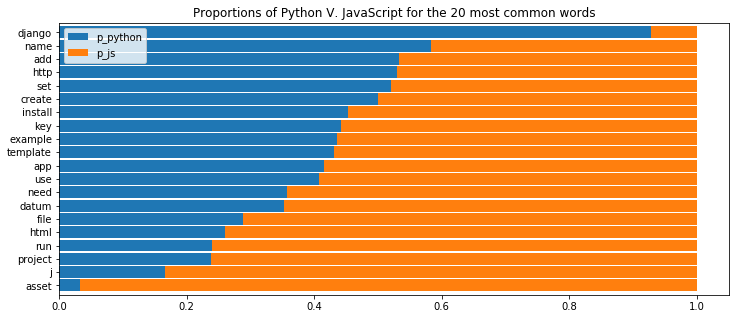

In [34]:
# figure out the percentage of language distribution
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_js=word_counts.js / word_counts['all']
        )
 .sort_values(by='all')
 [['p_python',
   'p_js'
  ]]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True, figsize=(12,5), width=.9))

plt.title('Proportions of Python V. JavaScript for the 20 most common words')

In [35]:
word_counts[(word_counts.python > 10) & (word_counts.js > 10)]\
    .assign(ratio=lambda df: df.python / df.js)\
    .sort_values(by='ratio')

,python,js,all,ratio
deploy,16,99,115,0.161616
config,13,77,90,0.168831
script,20,108,128,0.185185
j,37,185,222,0.200000
pull,11,52,63,0.211538
command,19,76,95,0.250000
update,13,51,64,0.254902
build,27,105,132,0.257143
google,26,100,126,0.260000
event,15,51,66,0.294118


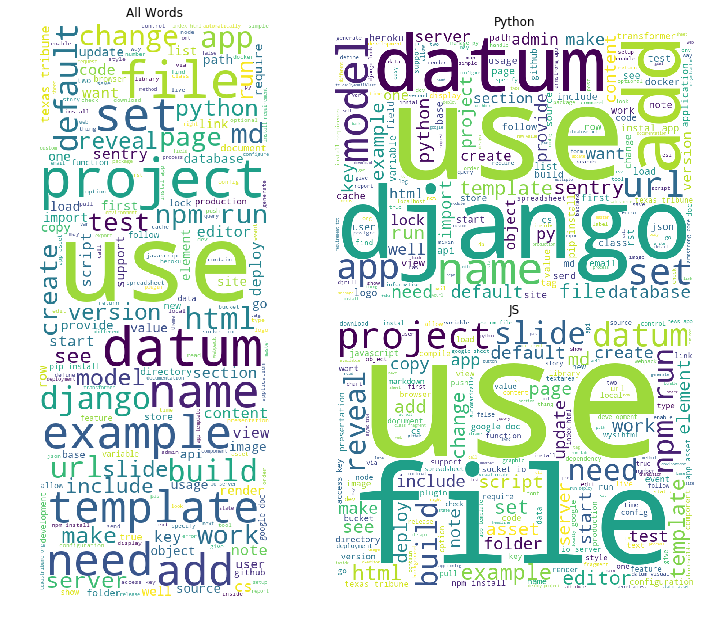

In [36]:
all_cloud = WordCloud(background_color='white', height=1000, width=400, random_state=123).generate(' '.join(all_words))
python_cloud = WordCloud(background_color='white', height=600, width=800, random_state=123).generate(' '.join(python_words))
js_cloud = WordCloud(background_color='white', height=600, width=800, random_state=123).generate(' '.join(js_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(python_cloud)
axs[2].imshow(js_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Python')
axs[2].set_title('JS')

for ax in axs: ax.axis('off')

In [37]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(instal, app)       36
(pip, install)      34
(texas, tribune)    24
(http, www)         23
(github, com)       23
dtype: int64

In [38]:
top_20_js_bigrams = (pd.Series(nltk.ngrams(js_words, 2))
                      .value_counts()
                      .head(20))

top_20_js_bigrams.head()

(npm, run)        89
(reveal, j)       43
(google, doc)     40
(npm, install)    36
(socket, io)      35
dtype: int64

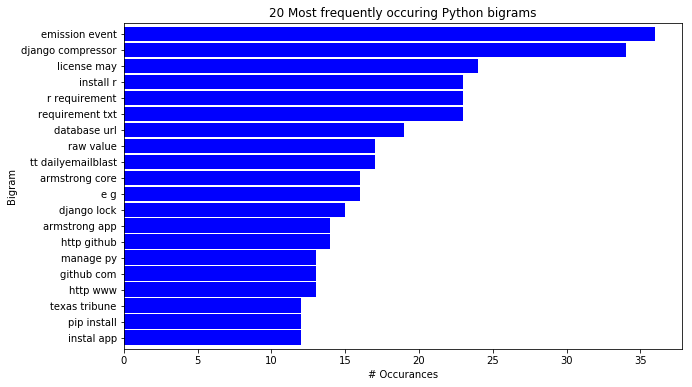

In [39]:
top_20_python_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
# TODO: fix the labels which are in reversed order
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

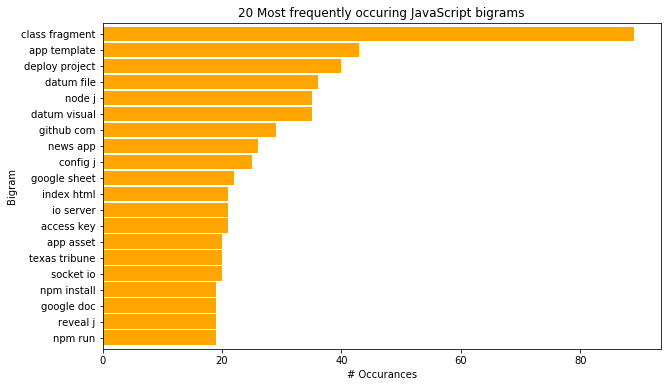

In [40]:
top_20_js_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
# TODO: fix the labels which are in reversed order
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

Text(0.5, 1.0, 'Top 20 Python Bigrams')

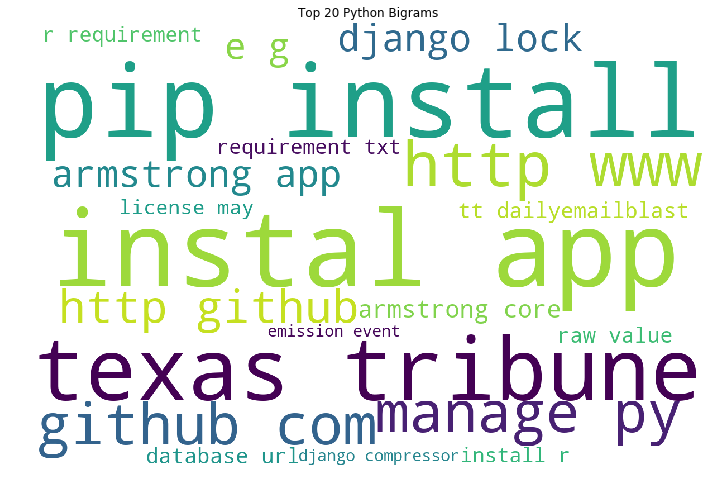

In [41]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=1200, height=800, random_state=123).generate_from_frequencies(data)

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 Python Bigrams')

Text(0.5, 1.0, 'Top 20 JavaScript Bigrams')

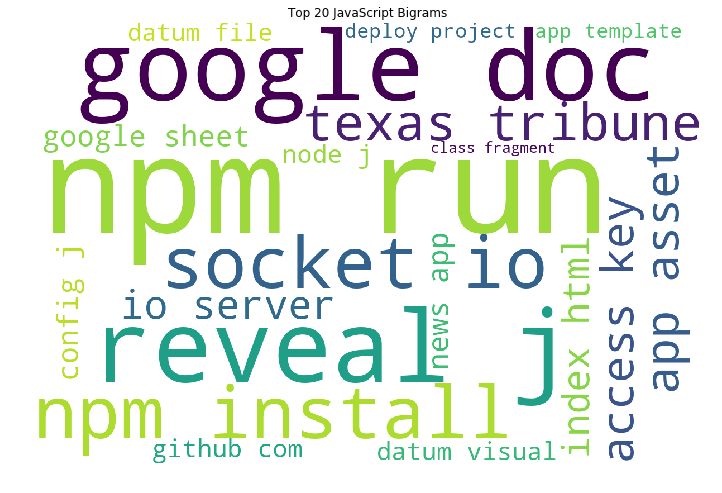

In [42]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_js_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=1200, height=800, random_state=123).generate_from_frequencies(data)
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 JavaScript Bigrams')

In [43]:
top_20_python_trigrams = (pd.Series(nltk.ngrams(python_words, 3))
                      .value_counts()
                      .head(20))

top_20_python_trigrams.head()

(http, github, com)          19
(pip, install, r)            13
(install, r, requirement)    13
(rio, grande, county)        11
(armstrong, core, arm)       11
dtype: int64

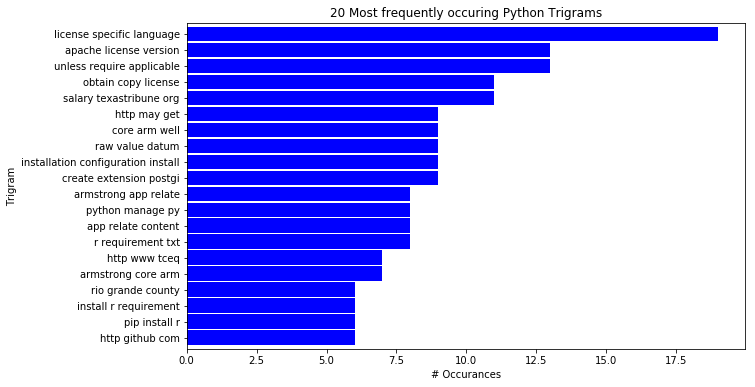

In [44]:
top_20_python_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 1199.5, 799.5, -0.5)

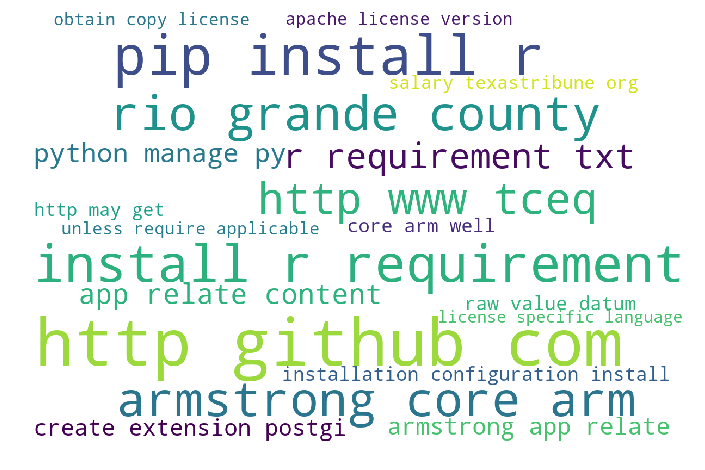

In [45]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_python_trigrams.to_dict().items()}
img_python_tri = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img_python_tri)
plt.axis('off')

In [46]:
top_20_js_trigrams = (pd.Series(nltk.ngrams(js_words, 3))
                      .value_counts()
                      .head(20))

top_20_js_trigrams.head()

(socket, io, server)     25
(http, github, com)      18
(j, async, true)         18
(secret, access, key)    16
(npm, run, deploy)       16
dtype: int64

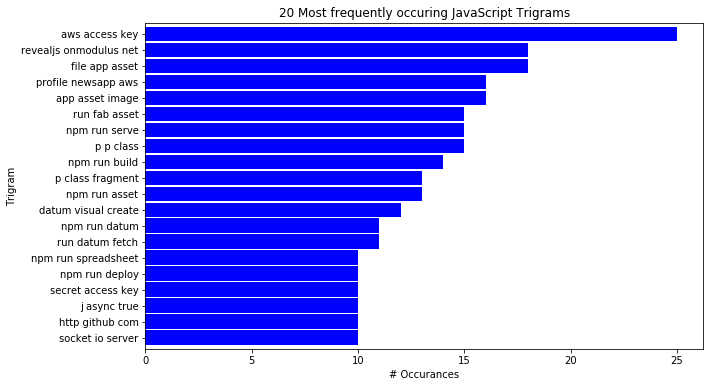

In [47]:
top_20_js_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 1199.5, 799.5, -0.5)

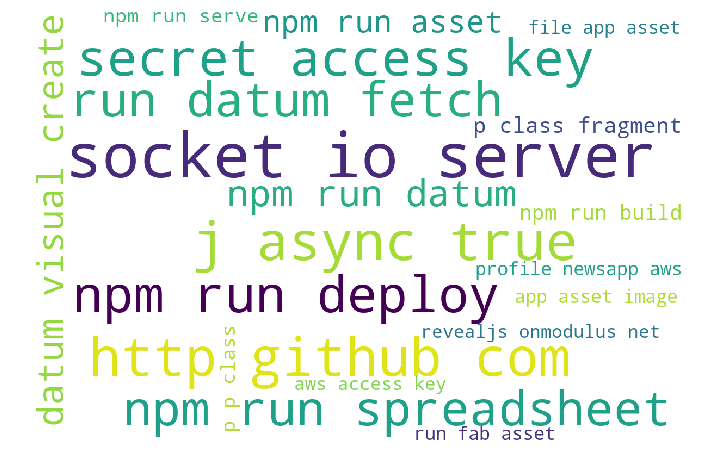

In [48]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_js_trigrams.to_dict().items()}
img_js_tri = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img_js_tri)
plt.axis('off')

## QUESTION:
### _Do different languages use a different number of unique words?_

In [49]:
df3 = df.copy()

In [50]:
df3.head()

,text,language
1,md software collect donation nonprofit integra...,Python
2,md datum visual create tool generate scaffoldi...,JavaScript
5,md texas tribune file app app power file syste...,JavaScript
9,md thermometer,Python
10,md wall query salesforce opportunity informati...,Python


In [51]:
df3_python = df3[df3.language == 'Python']
df3_python.shape

(68, 2)

In [52]:
df3_js = df3[df3.language == 'JavaScript']
df3_js.shape

(60, 2)

In [53]:
def flatten(lofl):     
    for i in lofl: 
        if type(i) == list: 
            flatten(i) 
        else: 
            output.append(i)
    return output

In [54]:
string_python = []
for text in df3_python.text.tolist():
    string_python.append(text.split())

In [55]:
output = []
words_in_python = pd.Series(flatten(string_python))
print(len(set(words_in_python)))

2305


In [56]:
string_js = []
for text in df3_js.text.tolist():
    string_js.append(text.split())

In [57]:
output = []
words_in_js = pd.Series(flatten(string_js))
print(len(set(words_in_js)))

2258


## ANSWER:
### _Yes, but not by much (relatively speaking). Repositories that are primarily written in Python have readme files that are on average 47 words more than those written in JavaScript._

# MODEL

## Train/Test Split

In [58]:
dfx1 = df.copy() # Logistic Regression with Cross Validation
dfx2 = df.copy() # KNN
dfx3 = df.copy() # Decision Tree
dfx4 = df.copy() # Random Forest

## 1. Logistic Regression With Cross Validation

In [59]:
tfidf1 = TfidfVectorizer()
X1 = tfidf1.fit_transform(dfx1.text)
y1 = dfx1.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.3)

train1 = pd.DataFrame(dict(actual=y1_train))
test1 = pd.DataFrame(dict(actual=y1_test))

lm = LogisticRegressionCV(random_state=493).fit(X1_train, y1_train)

train1['predicted'] = lm.predict(X1_train)
test1['predicted'] = lm.predict(X1_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [60]:
print('Accuracy: {:.2%}'.format(accuracy_score(train1.actual, train1.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train1.predicted, train1.actual))
print('---')
print(classification_report(train1.actual, train1.predicted))

Accuracy: 97.75%
---
Confusion Matrix
actual      JavaScript  Python
predicted                     
JavaScript          47       2
Python               0      40
---
              precision    recall  f1-score   support

  JavaScript       0.96      1.00      0.98        47
      Python       1.00      0.95      0.98        42

   micro avg       0.98      0.98      0.98        89
   macro avg       0.98      0.98      0.98        89
weighted avg       0.98      0.98      0.98        89



## 2.  K-Nearest Neighbors Model

In [61]:
tfidf2 = TfidfVectorizer()
X2 = tfidf2.fit_transform(dfx2.text)
y2 = dfx2.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=.3)

train2 = pd.DataFrame(dict(actual=y2_train))
test2 = pd.DataFrame(dict(actual=y2_test))

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X2_train, y2_train)

y2_pred = knn.predict(X2_train)
y2_pred_proba = knn.predict_proba(X2_train)

In [62]:
print('Accuracy: {:.2%}'.format(knn.score(X2_train, y2_train)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(y2_train, y2_pred))
print('---')
print(classification_report(y2_train, y2_pred))

Accuracy: 83.15%
---
Confusion Matrix
col_0       JavaScript  Python
language                      
JavaScript          43       0
Python              15      31
---
              precision    recall  f1-score   support

  JavaScript       0.74      1.00      0.85        43
      Python       1.00      0.67      0.81        46

   micro avg       0.83      0.83      0.83        89
   macro avg       0.87      0.84      0.83        89
weighted avg       0.88      0.83      0.83        89



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

## 3.  Decision Tree model

In [63]:
tfidf3 = TfidfVectorizer()
X3 = tfidf3.fit_transform(dfx3.text)
y3 = dfx3.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=.3)

train3 = pd.DataFrame(dict(actual=y3_train))
test3 = pd.DataFrame(dict(actual=y3_test))

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=493)

clf.fit(X3_train, y3_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=493,
            splitter='best')

In [64]:
y3_pred = clf.predict(X3_train)
y3_pred[0:5]

array(['JavaScript', 'JavaScript', 'JavaScript', 'JavaScript',
       'JavaScript'], dtype=object)

In [65]:
y3_pred_proba = clf.predict_proba(X3_train)
y3_pred_proba[0:5]

array([[1.        , 0.        ],
       [0.53658537, 0.46341463],
       [1.        , 0.        ],
       [0.53658537, 0.46341463],
       [0.53658537, 0.46341463]])

#### Evaluate Model
- *Compute the Accuracy*
- *Accuracy:  number of correct predictions over the number of total instances that have been evaluated.*

In [66]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X3_train, y3_train)))

Accuracy of Decision Tree classifier on training set: 0.78


In [67]:
confusion_matrix(y3_train, y3_pred)

array([[43,  1],
       [19, 26]])

In [68]:
y3_train.value_counts()

Python        45
JavaScript    44
Name: language, dtype: int64

In [69]:
labels = sorted(y3_train.unique())

In [70]:
pd.DataFrame(confusion_matrix(y3_train, y3_pred), index=labels, columns=labels)

,JavaScript,Python
JavaScript,43,1
Python,19,26


In [71]:
print(classification_report(y3_train, y3_pred))

              precision    recall  f1-score   support

  JavaScript       0.69      0.98      0.81        44
      Python       0.96      0.58      0.72        45

   micro avg       0.78      0.78      0.78        89
   macro avg       0.83      0.78      0.77        89
weighted avg       0.83      0.78      0.77        89



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

## 4. Random Forest

In [72]:
tfidf4 = TfidfVectorizer()
X4 = tfidf4.fit_transform(dfx4.text)
y4 = dfx4.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=.3)

train4 = pd.DataFrame(dict(actual=y4_train))
test4 = pd.DataFrame(dict(actual=y4_test))

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=493)

In [73]:
rf.fit(X4_train, y4_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=493, verbose=0, warm_start=False)

In [74]:
y4_pred = rf.predict(X4_train)
y4_pred_proba = rf.predict_proba(X4_train)

In [75]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X4_train, y4_train)))

Accuracy of random forest classifier on training set: 0.85


In [76]:
print(confusion_matrix(y4_train, y4_pred))

[[28 13]
 [ 0 48]]


In [77]:
print(classification_report(y4_train, y4_pred))

              precision    recall  f1-score   support

  JavaScript       1.00      0.68      0.81        41
      Python       0.79      1.00      0.88        48

   micro avg       0.85      0.85      0.85        89
   macro avg       0.89      0.84      0.85        89
weighted avg       0.89      0.85      0.85        89



## Logistic Regression with Cross Validation on the TEST SET

In [78]:
print('Accuracy: {:.2%}'.format(accuracy_score(test1.actual, test1.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test1.predicted, test1.actual))
print('---')
print(classification_report(test1.actual, test1.predicted))

Accuracy: 76.92%
---
Confusion Matrix
actual      JavaScript  Python
predicted                     
JavaScript           8       4
Python               5      22
---
              precision    recall  f1-score   support

  JavaScript       0.67      0.62      0.64        13
      Python       0.81      0.85      0.83        26

   micro avg       0.77      0.77      0.77        39
   macro avg       0.74      0.73      0.74        39
weighted avg       0.77      0.77      0.77        39



## Build a function that will take in the text of a README file, and makes a prediction of language.

In [81]:
def predict(unknown_text):
    return lm.predict(tfidf1.transform([unknown_text]))[0]

In [83]:
corpus = get_github_repo('https://github.com/airbnb/javascript')['readme']
predict(corpus)

'JavaScript'